In [86]:
%matplotlib inline
import pandas as pd
import os

# Define file paths
path1 = '../mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/'
path2 = '../mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/'

# List of all unique filenames across both directories
all_files = [
    'dailyActivity_merged.csv',
    'heartrate_seconds_merged.csv',
    'hourlyCalories_merged.csv',
    'hourlyIntensities_merged.csv',
    'sleepDay_merged.csv',
    'weightLogInfo_merged.csv'
]

# Dictionary to store clean dataframes
data = {}

for filename in all_files:
    file_path1 = os.path.join(path1, filename)
    file_path2 = os.path.join(path2, filename)
    
    df_list = []
    
    # Check and load from first directory
    if os.path.exists(file_path1):
        df_list.append(pd.read_csv(file_path1))
        
    # Check and load from second directory
    if os.path.exists(file_path2):
        df_list.append(pd.read_csv(file_path2))
    
    # Merge if data exists
    if df_list:
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Create clean name (remove _merged.csv)
        clean_name = filename.replace('_merged.csv', '')
        data[clean_name] = combined_df
        
        print(f"Loaded {clean_name}: {combined_df.shape}")
    else:
        print(f"Warning: {filename} not found in either directory.")

# Clean up keys for easier access (optional: create individual variables)
# locals().update(data) # Uncomment to create variables like dailyActivity, heartrate_seconds etc.

print("\nAll files loaded successfully into 'data' dictionary.")

Loaded dailyActivity: (1397, 15)
Loaded heartrate_seconds: (3638339, 3)
Loaded hourlyCalories: (46183, 3)
Loaded hourlyIntensities: (46183, 4)
Loaded sleepDay: (413, 5)
Loaded weightLogInfo: (100, 8)

All files loaded successfully into 'data' dictionary.


In [ ]:
daily_activity = data['dailyActivity']
daily_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        1397 non-null   int64  
 1   ActivityDate              1397 non-null   object 
 2   TotalSteps                1397 non-null   int64  
 3   TotalDistance             1397 non-null   float64
 4   TrackerDistance           1397 non-null   float64
 5   LoggedActivitiesDistance  1397 non-null   float64
 6   VeryActiveDistance        1397 non-null   float64
 7   ModeratelyActiveDistance  1397 non-null   float64
 8   LightActiveDistance       1397 non-null   float64
 9   SedentaryActiveDistance   1397 non-null   float64
 10  VeryActiveMinutes         1397 non-null   int64  
 11  FairlyActiveMinutes       1397 non-null   int64  
 12  LightlyActiveMinutes      1397 non-null   int64  
 13  SedentaryMinutes          1397 non-null   int64  
 14  Calories

In [ ]:
# To change column names to snake case
import re
import pandas as pd

def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()


for col in daily_activity.columns:
    daily_activity.rename(columns={col: to_snake_case(col)}, inplace=True)



In [ ]:
# information about the dataset
daily_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          1397 non-null   int64         
 1   activity_date               1397 non-null   datetime64[ns]
 2   total_steps                 1397 non-null   int64         
 3   total_distance              1397 non-null   float64       
 4   tracker_distance            1397 non-null   float64       
 5   logged_activities_distance  1397 non-null   float64       
 6   very_active_distance        1397 non-null   float64       
 7   moderately_active_distance  1397 non-null   float64       
 8   light_active_distance       1397 non-null   float64       
 9   sedentary_active_distance   1397 non-null   float64       
 10  very_active_minutes         1397 non-null   int64         
 11  fairly_active_minutes       1397 non-null   int64       

In [90]:
#Date Parsing & Validation

daily_activity["activity_date"] = pd.to_datetime(daily_activity["activity_date"])
daily_activity ["activity_date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1397 entries, 0 to 1396
Series name: activity_date
Non-Null Count  Dtype         
--------------  -----         
1397 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 11.0 KB


In [91]:
#Duplicate & Logical Integrity Checks
daily_activity.duplicated().sum()

np.int64(0)

In [92]:
# num of unique rows
daily_activity.nunique()

id                              35
activity_date                   62
total_steps                   1208
total_distance                 781
tracker_distance               780
logged_activities_distance      35
very_active_distance           410
moderately_active_distance     243
light_active_distance          591
sedentary_active_distance       10
very_active_minutes            130
fairly_active_minutes           93
lightly_active_minutes         379
sedentary_minutes              684
calories                       995
dtype: int64

In [93]:
#Data Quality & Anomaly Checks

In [130]:
# Zero-Activity Days
(daily_activity["total_steps"] == 0).mean() * 100
(daily_activity["calories"] < 1200).sum()


np.int64(48)

In [ ]:
# consistency check because a day should have 1440 minutes
daily_activity["total_minutes"] = (
    daily_activity["very_active_minutes"]
    + daily_activity["fairly_active_minutes"]
    + daily_activity["lightly_active_minutes"]
    + daily_activity["sedentary_minutes"]
)

daily_activity["total_minutes"].describe()


count    1397.000000
mean     1210.997853
std       279.946248
min         2.000000
25%       988.000000
50%      1440.000000
75%      1440.000000
max      1440.000000
Name: total_minutes, dtype: float64

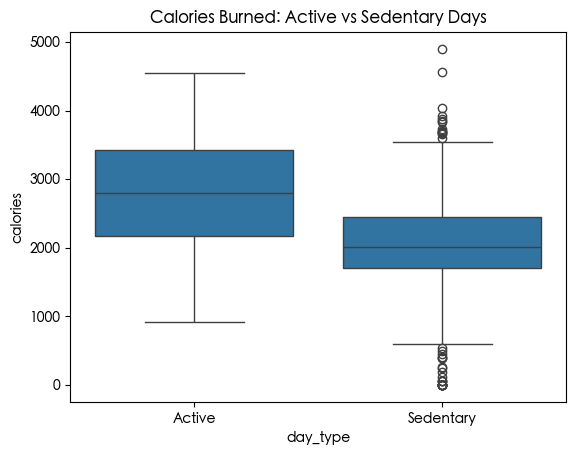

In [ ]:
#Active vs Sedentary Days
daily_activity["day_type"] = np.where(
    daily_activity["very_active_minutes"] >= 30,
    "Active",
    "Sedentary"
)

daily_activity["day_type"].value_counts(normalize=True)

sns.boxplot(
    data=daily_activity,
    x="day_type",
    y="calories"
)
plt.title("Calories Burned: Active vs Sedentary Days")
plt.show()



In [ ]:
# 6. Descriptive Statistics & Distributions

In [101]:
# 6.1 Core Activity Metrics

daily_activity[["total_steps", "total_distance", "calories"]].describe()


,total_steps,total_distance,calories
count,1397.000000,1397.000000,1397.000000
mean,7280.898354,5.219434,2266.265569
std,5214.336113,3.994206,753.005527
min,0.000000,0.000000,0.000000
25%,3146.000000,2.170000,1799.000000
50%,6999.000000,4.950000,2114.000000
75%,10544.000000,7.500000,2770.000000
max,36019.000000,28.030001,4900.000000


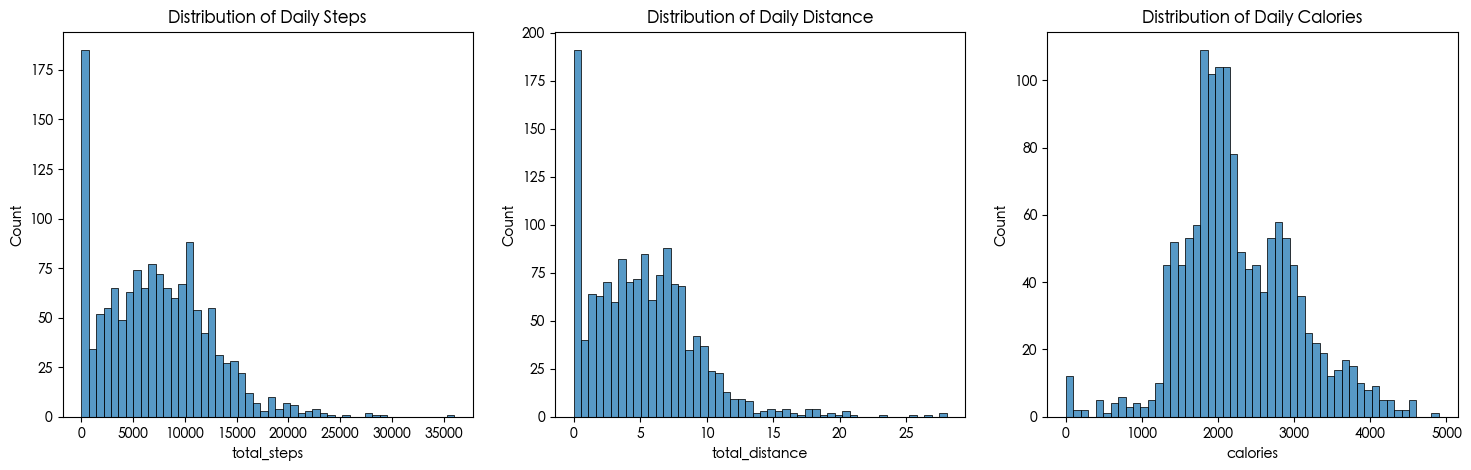

In [ ]:
# distribution histograms
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(daily_activity["total_steps"], bins=50, ax=axes[0])
axes[0].set_title("Distribution of Daily Steps")

sns.histplot(daily_activity["total_distance"], bins=50, ax=axes[1])
axes[1].set_title("Distribution of Daily Distance")

sns.histplot(daily_activity["calories"], bins=50, ax=axes[2])
axes[2].set_title("Distribution of Daily Calories")

plt.show()


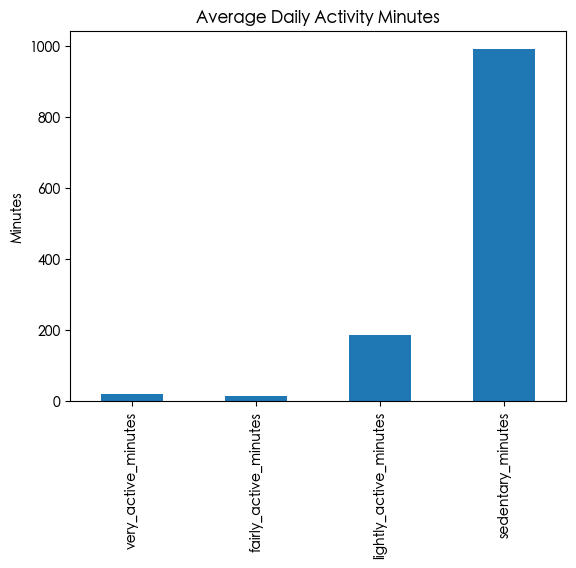

In [115]:
#7. Activity Intensity Breakdown

activity_minutes = daily_activity[
    ["very_active_minutes", "fairly_active_minutes",
     "lightly_active_minutes", "sedentary_minutes"]
].mean()

activity_minutes.plot(kind="bar", title="Average Daily Activity Minutes")
plt.ylabel("Minutes")
plt.show()


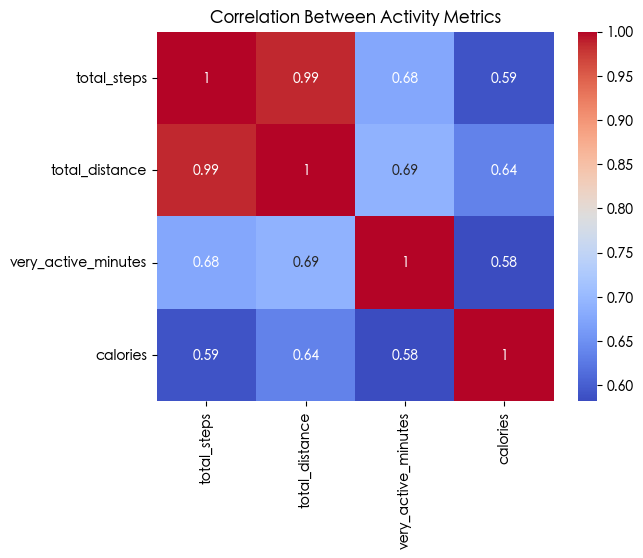

In [117]:
# 8. Relationship & Correlation Analysis
# 8.1 Correlation Matrix

corr = daily_activity[
    ["total_steps", "total_distance", 
     "very_active_minutes", "calories"]
].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Activity Metrics")
plt.show()


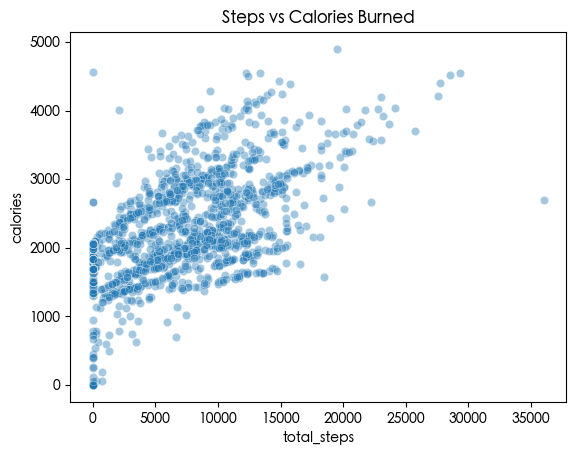

In [118]:
#8.2 Steps vs Calories

sns.scatterplot(x="total_steps", y="calories", data=daily_activity, alpha=0.4)
plt.title("Steps vs Calories Burned")
plt.show()


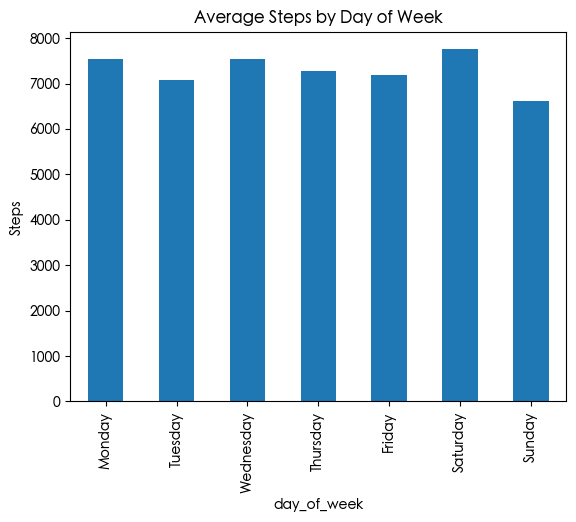

In [127]:
daily_activity["day_of_week"] = (
    daily_activity["activity_date"].dt.day_name()
)

weekly_steps = (
    daily_activity.groupby("day_of_week")["total_steps"]
    .mean()
    .reindex([
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ])
)

weekly_steps.plot(
    kind="bar",
    title="Average Steps by Day of Week"
)
plt.ylabel("Steps")
plt.show()
